In [96]:
import numpy as np
import pandas as pd

In [6]:
import json

In [7]:
from pathlib import Path

In [8]:
path = Path('../../euromomo/euro_momo_extract_1.json')

In [9]:
with open(path) as json_file:
    data = json.load(json_file)

In [258]:
pooledByAgeGroup = data['result']['data']['graphsJson']['pooledByAgeGroup']

In [113]:
pd.concat([pd.DataFrame(pooledByAgeGroup['counts'][0]['data'][0]['data'])

SyntaxError: unexpected EOF while parsing (<ipython-input-113-99dcee7a270c>, line 1)

### get counts etc by age by week

In [10]:
def my_crowler(a, is_verbose=False):
    if type(a) is list and type(a[0]) is dict and 'x' in a[0].keys():
        if is_verbose:
            print('list dict xy')
        return pd.DataFrame(a)
    
    elif type(a) is list and type(a[0]) in [str, int, float]:
        if is_verbose:
            print('list number')
        return pd.DataFrame(data=a, columns=['y'])
    
    elif type(a) is list:
        if is_verbose:
            print('general list')
        return pd.concat([my_crowler(item) for item in a])
    
    elif type(a) is dict and 'id' in a.keys() and 'data' in a.keys():
        if is_verbose:
            print('dict')
        #pd.DataFrame({k : v} for k, v in a if not k in ['id', 'data'])
        to_concat = [my_crowler(a['data']),]
        #keys = [a['id'],]
        for k, v in a.items():
            #print(k)
            if k not in ['id', 'data']:
                to_concat += [pd.concat([my_crowler(v),], keys=[k,])]
                #keys += [k, ]
        return pd.concat([pd.concat(to_concat),], keys=[a['id'],])#keys=keys)

    
    
l1 = []
l2 = []
for k, v in pooledByAgeGroup['counts'][0].items():
    if k not in ['id', 'data']:
        l1 += [my_crowler(v), ]
        l2 += [k, ]
        
pd.concat(l1, keys=l2)

### some steps of development

In [194]:
_ = my_crowler(pooledByAgeGroup['counts'][0]['data'][0]['data'])
_

list dict xy


x           y
0      0  334.364773
1      1  334.262601
2      2  334.160870
3      3  334.059642
4      4  333.958741
..   ...         ...
219  219  321.352517
220  220  321.333520
221  221  321.314651
222  222  322.142727
223  223  321.267616

[224 rows x 2 columns]

In [140]:
_ = my_crowler(pooledByAgeGroup['counts'][0]['data'][1])

dict
list dict xy


In [141]:
_ = my_crowler(pooledByAgeGroup['counts'][0]['data'])


general list
dict
list dict xy
dict
list dict xy


In [148]:
_ = my_crowler(pooledByAgeGroup['counts'][0])
#_.index

dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number


In [155]:
_ = my_crowler(pooledByAgeGroup['counts'])
_.index.to_frame(False)

general list
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number


0    1    2
0      0to4   si    0
1      0to4   si    1
2      0to4   si    2
3      0to4   si    3
4      0to4   si    4
...     ...  ...  ...
5595  Total  lnr  219
5596  Total  lnr  220
5597  Total  lnr  221
5598  Total  lnr  222
5599  Total  lnr  223

[5600 rows x 3 columns]

In [156]:
_ = my_crowler(pooledByAgeGroup['zscores'])
_.index.to_frame(False)

general list
dict
general list
dict
list dict xy
dict
general list
dict
list dict xy
dict
general list
dict
list dict xy
dict
general list
dict
list dict xy
dict
general list
dict
list dict xy


0       1    2
0      0to4  zscore    0
1      0to4  zscore    1
2      0to4  zscore    2
3      0to4  zscore    3
4      0to4  zscore    4
...     ...     ...  ...
1115  Total  zscore  219
1116  Total  zscore  220
1117  Total  zscore  221
1118  Total  zscore  222
1119  Total  zscore  223

[1120 rows x 3 columns]

### parse pooled by age group

In [491]:
out = my_crowler([pooledByAgeGroup['counts'], pooledByAgeGroup['zscores']])
out = out.y
out = out.unstack([0, 1])
out.columns.names = 'age_group', 'measure'

general list
general list
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
dict
general list
dict
list dict xy
dict
list dict xy
list number
list number
list number
general list
dict
general list
dict
list dict xy
dict
general list
dict
list dict xy
dict
general list
dict
list dict xy
dict
general list
dict
list dict xy
dict
general list
dict
list dict xy


In [60]:
def get_datetime_from_year_week(year_week, manual_shift_fix):
    """
    please note the important part: I check that the result fits perfectly
    """
    start = str(year_week.year[0])
    calculated_ts = (pd.Timestamp(start) - pd.Timedelta(pd.Timestamp(start).dayofweek) + pd.timedelta_range(start=f'{manual_shift_fix}D', periods=len(year_week), freq='7D')).normalize()
    converting_to_year_week = pd.DataFrame({'year' : calculated_ts.year, 'week' : calculated_ts.week})
    assert not (converting_to_year_week - year_week).values.any()
    #return converting_to_year_week - year_week
    #return converting_to_year_week

    return calculated_ts


In [497]:
year_week = pd.Series(pooledByAgeGroup['weeks']).str.split('-', expand=True).astype(int).rename(columns={0:'year', 1:'week'})
manual_shift_fix = 6 #6 pooled, #1 zscore by country


calculated_ts = get_datetime_from_year_week(year_week, manual_shift_fix)
out.index = calculated_ts
out.index.name = 'date'

In [509]:
path

PosixPath('../../euromomo/euro_momo_extract_1.json')

In [510]:
out.to_csv(path.parent.joinpath('euromomo_by_age_all_measures_2.csv'))

### little bit of observation and splitting by years

out2 = pd.read_csv(path.parent.joinpath('euromomo_by_age_all_measures.csv'), index_col=[0, 1], parse_dates=True)

In [511]:
out2 = pd.read_csv(path.parent.joinpath('euromomo_by_age_all_measures_2.csv'), index_col=0, parse_dates=True, header=[0, 1])

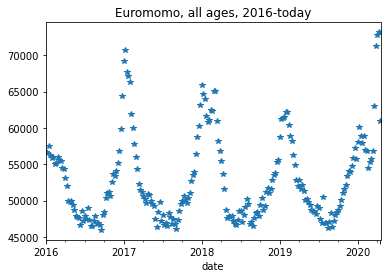

In [513]:
out2['Total']['count'].plot(linestyle='', marker='*', title='Euromomo, all ages, 2016-today')

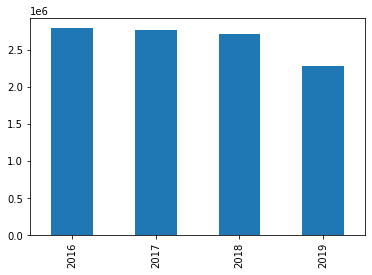

In [514]:
out2['Total']['count'].groupby(by=lambda x : (x - pd.Timedelta(180, unit='day')).year).sum().iloc[1:].plot.bar()

In [515]:
out2['Total']['count'].groupby(by=lambda x : (x - pd.Timedelta(180, unit='day')).year).get_group(2018)

date
2018-07-04    48637.0000
2018-07-11    47104.0000
2018-07-18    48056.0000
2018-07-25    49144.0000
2018-08-01    50223.0000
2018-08-08    49488.0000
2018-08-15    46797.0000
2018-08-22    47053.0000
2018-08-29    46459.0000
2018-09-05    47623.0000
2018-09-12    48240.0000
2018-09-19    48369.0000
2018-09-26    47849.0000
2018-10-03    49412.0000
2018-10-10    50410.0000
2018-10-17    48743.0000
2018-10-24    49202.0000
2018-10-31    51232.0000
2018-11-07    51736.0000
2018-11-14    50993.0000
2018-11-21    51640.0000
2018-11-28    52771.0000
2018-12-05    53460.0000
2018-12-12    53745.0000
2018-12-19    55312.0000
2018-12-26    55627.0000
2019-01-02    58791.0000
2019-01-09    61272.0000
2019-01-16    61322.0000
2019-01-23    61438.0000
2019-01-30    62124.0000
2019-02-06    62171.0000
2019-02-13    60417.0000
2019-02-20    58946.0000
2019-02-27    58191.0000
2019-03-06    56324.0000
2019-03-13    54951.0000
2019-03-20    52799.0000
2019-03-27    51953.0000
2019-04-03    52872.

### taking only count, split by year, split by winter year

In [531]:
out3 = pd.DataFrame(out2['Total']['count'])
out3['year'] = out3.index.year
out3['week_in_year'] = out3.index.week
#out3.index = 
#out3['week_in_year'] = pd.Series(out3.index).copy().dt.week

In [532]:
my_l = []
for k in out3.groupby('year').groups.keys():
    d = out3.groupby('year').get_group(k)
    d.index = d['week_in_year']
    d = d[['count']]
    d = d.rename(columns={'count' : k})
    d = d.T
    my_l.append(d)
    #[out3.groupby('year').get_group(k).reset_index('week_in_year').T for k in ]

out4 = pd.concat(my_l)
out4.index.name = 'year'
out4.to_csv(path.parent.joinpath('euromomo_count_total_ages_total_countries_by_year_weak.csv'))

### now winter years

In [540]:
tmp = out2['Total']['count']
new_ind = pd.MultiIndex.from_frame(pd.DataFrame({'year' : tmp.index.year, 'week' : tmp.index.week}))
tmp.index = new_ind
tmp.unstack(0).to_csv(path.parent.joinpath('euromomo_count_total_ages_total_countries_by_year_week_2.csv'))

In [542]:
tmp

year  week
2016  1       56688.000000
      2       56598.000000
      3       57444.000000
      4       56309.000000
      5       55844.000000
                  ...     
2020  12      63033.070600
      13      71201.858216
      14      72788.823829
      15      73148.549323
      16      60973.182619
Name: count, Length: 224, dtype: float64

year  week
2016  1       2015.5
      2       2015.5
      3       2015.5
      4       2015.5
      5       2015.5
               ...  
2020  12      2019.5
      13      2019.5
      14      2019.5
      15      2019.5
      16      2019.5
Length: 224, dtype: float64

In [605]:
ind_frame = new_ind.to_frame()
thresh = pd.Timestamp('2015/06/01').week + 0.5
print(thresh)
ind_frame['year_winter'] = (thresh <= ind_frame.week) * 1 - 0.5 + ind_frame.year
#np.sign((ind_frame.week - thresh) % 52 - 26) / 2 + ind_frame.year



tmp = out2['Total']['count']
new_ind = pd.MultiIndex.from_frame(pd.DataFrame({'year' : tmp.index.year, 'week' : tmp.index.week}))
ind_frame = new_ind.to_frame()
thresh = pd.Timestamp('2015/06/01').week + 0.5
print(thresh)
ind_frame['year_winter'] = (thresh <= ind_frame.week) * 1 - 0.5 + ind_frame.year
ind_frame = ind_frame[['year_winter', 'week']]



tmp.index = pd.MultiIndex.from_frame(ind_frame)
tmp.unstack(0).to_csv(path.parent.joinpath('euromomo_count_total_ages_total_countries_by_year_week_2_winter_years.csv'))

23.5
23.5


### normal vec

In [610]:
tmp = pd.DataFrame(out2['Total']['count'])
tmp['year'] = tmp.index.year
tmp['week_of_year'] = tmp.index.week
tmp = tmp[['year', 'week_of_year', 'count']]
tmp.to_csv(path.parent.joinpath('euromomo_count_total_ages_.csv'))
#tmp['week_from_beginning'] = tmp.week.diff()
#new_ind = pd.MultiIndex.from_frame(pd.DataFrame({'year' : tmp.index.year, 'week' : tmp.index.week}))
#tmp.index = new_ind
#tmp.unstack(0).to_csv(path.parent.joinpath('euromomo_count_total_ages_total_countries_by_year_week_2.csv'))

year  week_of_year         count
date                                        
2016-01-06  2016             1  56688.000000
2016-01-13  2016             2  56598.000000
2016-01-20  2016             3  57444.000000
2016-01-27  2016             4  56309.000000
2016-02-03  2016             5  55844.000000
...          ...           ...           ...
2020-03-18  2020            12  63033.070600
2020-03-25  2020            13  71201.858216
2020-04-01  2020            14  72788.823829
2020-04-08  2020            15  73148.549323
2020-04-15  2020            16  60973.182619

[224 rows x 3 columns]

### 3

### compare garphs to euro momo

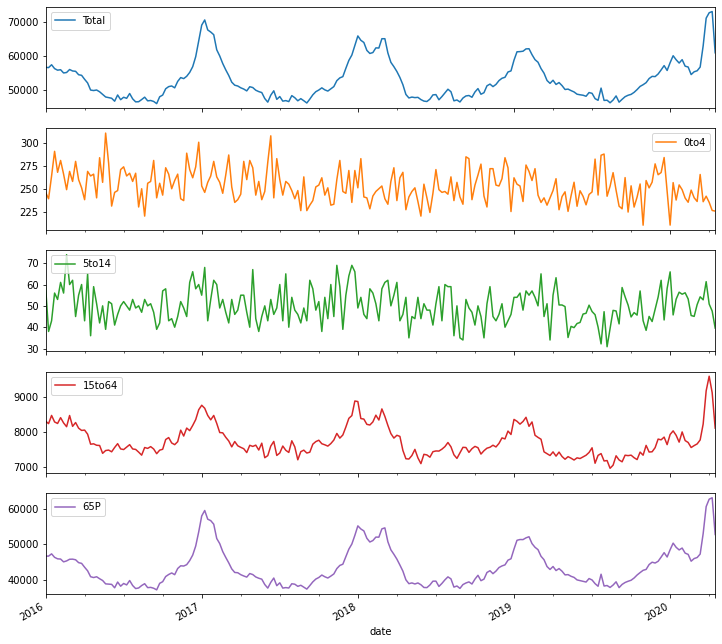

In [517]:
#fig, ax = plt.subplots(figsize=(12, 12))
df = out2.xs('count', level='measure', axis=1)
df = df[['Total', '0to4', '5to14', '15to64', '65P']]
axes = df.plot(subplots=True, figsize=(12, 12))
fig = axes[0].get_figure()
fig.savefig(Path.home().joinpath('Downloads/euro_momo_parsed_counts_by_age.jpeg'))

### zscore analysis

In [519]:
tot = out2['Total']

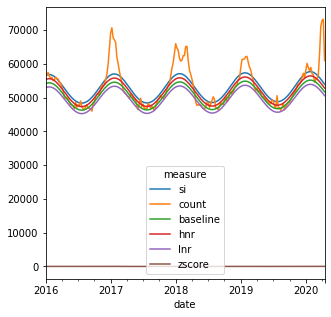

In [518]:
out2['Total'].plot(figsize=(5, 5))

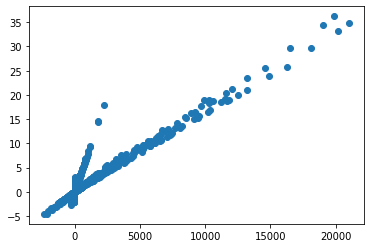

In [524]:
fig, ax = plt.subplots()
ax.scatter(out2.xs('count', level='measure', axis=1) - out2.xs('baseline', level='measure', axis=1), out2.xs('zscore', level='measure', axis=1))

In [192]:
import matplotlib.pyplot as plt
from sklearn import linear_model

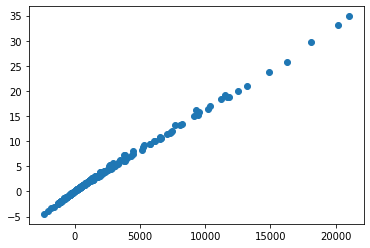

In [190]:
#((tot['count'] - tot.baseline) / tot.zscore).plot(linestyle='', marker='*')
#for_age = tot = out2.loc['Total']
fig, ax = plt.subplots()
x = (tot['count'] - tot.baseline).values.reshape(-1, 1)
y = tot.zscore.va
ax.scatter(, tot.zscore)

### some shit

In [95]:
out3.index

Index([2016-01-08 00:00:00, 2016-01-15 00:00:00, 2016-01-22 00:00:00,
       2016-01-29 00:00:00, 2016-02-05 00:00:00, 2016-02-12 00:00:00,
       2016-02-19 00:00:00, 2016-02-26 00:00:00, 2016-03-04 00:00:00,
       2016-03-11 00:00:00,
       ...
       2020-02-26 00:00:00, 2020-03-04 00:00:00, 2020-03-11 00:00:00,
       2020-03-18 00:00:00, 2020-03-25 00:00:00, 2020-04-01 00:00:00,
       2020-04-08 00:00:00, 2020-04-15 00:00:00, 2020-04-22 00:00:00,
                   'year_'],
      dtype='object', name='date', length=225)

In [93]:
pd.Series(out3.index.values.copy())

0     2016-01-08
1     2016-01-15
2     2016-01-22
3     2016-01-29
4     2016-02-05
         ...    
219   2020-03-25
220   2020-04-01
221   2020-04-08
222   2020-04-15
223   2020-04-22
Length: 224, dtype: datetime64[ns]

In [78]:
pd.Series(out3.index).dt.year

0       1
1       2
2       3
3       4
4       5
       ..
219    13
220    14
221    15
222    16
223    17
Name: date, Length: 224, dtype: int64

In [74]:
out3.index.

DatetimeIndex(['2016-01-08', '2016-01-15', '2016-01-22', '2016-01-29',
               '2016-02-05', '2016-02-12', '2016-02-19', '2016-02-26',
               '2016-03-04', '2016-03-11',
               ...
               '2020-02-19', '2020-02-26', '2020-03-04', '2020-03-11',
               '2020-03-18', '2020-03-25', '2020-04-01', '2020-04-08',
               '2020-04-15', '2020-04-22'],
              dtype='datetime64[ns]', name='date', length=224, freq=None)

In [33]:
out2.index.to_frame(False).date.dt.week

0        1
1        1
2        1
3        1
4        1
        ..
1115    17
1116    17
1117    17
1118    17
1119    17
Name: date, Length: 1120, dtype: int64

In [274]:
dfs = { n : _.get_group(n) for n in _.groups.keys()}

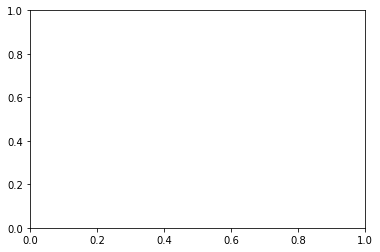

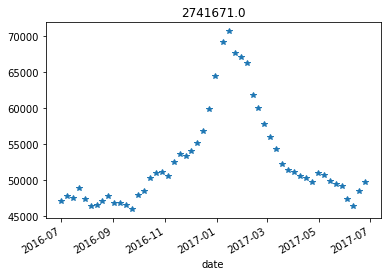

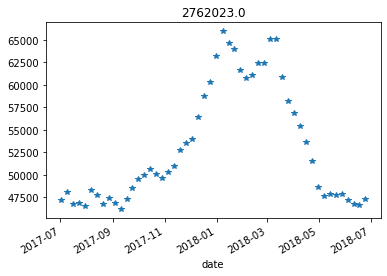

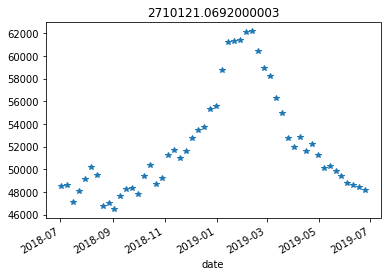

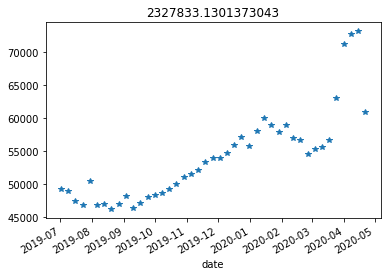

In [299]:
import matplotlib.pyplot as plt


for i, d in enumerate(dfs.values()):
    fig, ax = plt.subplots()
    if i == 0:
        continue
    d.plot(ax=ax, linestyle='', marker='*')
    ax.set_title(d.sum())
    
    

In [129]:
pd.concat([my_crowler(item) for item in pooledByAgeGroup['counts'][0]['data']])

dict
list dict xy
id
data
dict
list dict xy
id
data


x           y
si    0      0  334.364773
      1      1  334.262601
      2      2  334.160870
      3      3  334.059642
      4      4  333.958741
...        ...         ...
count 219  219  235.775481
      220  220  241.805602
      221  221  235.108788
      222  222  226.191710
      223  223  225.492498

[448 rows x 2 columns]

In [125]:
pooledByAgeGroup['counts'][0]['data']

[{'id': 'si',
  'data': [{'x': 0, 'y': 334.3647733098262},
   {'x': 1, 'y': 334.2626011836599},
   {'x': 2, 'y': 334.16087027594835},
   {'x': 3, 'y': 334.0596423161221},
   {'x': 4, 'y': 333.95874131582343},
   {'x': 5, 'y': 333.85856922095445},
   {'x': 6, 'y': 333.7582025098686},
   {'x': 7, 'y': 333.658627219317},
   {'x': 8, 'y': 333.55934093606504},
   {'x': 9, 'y': 333.4609798481445},
   {'x': 10, 'y': 333.3622820192683},
   {'x': 11, 'y': 333.26429047831937},
   {'x': 12, 'y': 333.16685040957486},
   {'x': 13, 'y': 333.06968265196514},
   {'x': 14, 'y': 332.972945620659},
   {'x': 15, 'y': 332.8767365300547},
   {'x': 16, 'y': 332.7801705875718},
   {'x': 17, 'y': 332.68547391634416},
   {'x': 18, 'y': 332.5921331981165},
   {'x': 19, 'y': 332.49617863437044},
   {'x': 20, 'y': 332.40157006022713},
   {'x': 21, 'y': 332.30774865656554},
   {'x': 22, 'y': 332.21437934244364},
   {'x': 23, 'y': 332.1215244000487},
   {'x': 24, 'y': 332.0290431473243},
   {'x': 25, 'y': 331.936845

In [124]:
my_crowler(pooledByAgeGroup['counts'][0]['data'])

{'id': 'si', 'data': [{'x': 0, 'y': 334.3647733098262}, {'x': 1, 'y': 334.2626011836599}, {'x': 2, 'y': 334.16087027594835}, {'x': 3, 'y': 334.0596423161221}, {'x': 4, 'y': 333.95874131582343}, {'x': 5, 'y': 333.85856922095445}, {'x': 6, 'y': 333.7582025098686}, {'x': 7, 'y': 333.658627219317}, {'x': 8, 'y': 333.55934093606504}, {'x': 9, 'y': 333.4609798481445}, {'x': 10, 'y': 333.3622820192683}, {'x': 11, 'y': 333.26429047831937}, {'x': 12, 'y': 333.16685040957486}, {'x': 13, 'y': 333.06968265196514}, {'x': 14, 'y': 332.972945620659}, {'x': 15, 'y': 332.8767365300547}, {'x': 16, 'y': 332.7801705875718}, {'x': 17, 'y': 332.68547391634416}, {'x': 18, 'y': 332.5921331981165}, {'x': 19, 'y': 332.49617863437044}, {'x': 20, 'y': 332.40157006022713}, {'x': 21, 'y': 332.30774865656554}, {'x': 22, 'y': 332.21437934244364}, {'x': 23, 'y': 332.1215244000487}, {'x': 24, 'y': 332.0290431473243}, {'x': 25, 'y': 331.93684514135504}, {'x': 26, 'y': 331.8451472557382}, {'x': 27, 'y': 331.7536651708577

x           y
si    0      0  334.364773
      1      1  334.262601
      2      2  334.160870
      3      3  334.059642
      4      4  333.958741
...        ...         ...
count 219  219  235.775481
      220  220  241.805602
      221  221  235.108788
      222  222  226.191710
      223  223  225.492498

[448 rows x 2 columns]

In [116]:
pooledByAgeGroup['counts'][0]['data']

[{'id': 'si',
  'data': [{'x': 0, 'y': 334.3647733098262},
   {'x': 1, 'y': 334.2626011836599},
   {'x': 2, 'y': 334.16087027594835},
   {'x': 3, 'y': 334.0596423161221},
   {'x': 4, 'y': 333.95874131582343},
   {'x': 5, 'y': 333.85856922095445},
   {'x': 6, 'y': 333.7582025098686},
   {'x': 7, 'y': 333.658627219317},
   {'x': 8, 'y': 333.55934093606504},
   {'x': 9, 'y': 333.4609798481445},
   {'x': 10, 'y': 333.3622820192683},
   {'x': 11, 'y': 333.26429047831937},
   {'x': 12, 'y': 333.16685040957486},
   {'x': 13, 'y': 333.06968265196514},
   {'x': 14, 'y': 332.972945620659},
   {'x': 15, 'y': 332.8767365300547},
   {'x': 16, 'y': 332.7801705875718},
   {'x': 17, 'y': 332.68547391634416},
   {'x': 18, 'y': 332.5921331981165},
   {'x': 19, 'y': 332.49617863437044},
   {'x': 20, 'y': 332.40157006022713},
   {'x': 21, 'y': 332.30774865656554},
   {'x': 22, 'y': 332.21437934244364},
   {'x': 23, 'y': 332.1215244000487},
   {'x': 24, 'y': 332.0290431473243},
   {'x': 25, 'y': 331.936845

In [112]:
pooledByAgeGroup['counts'][0]['data'][2]

IndexError: list index out of range

In [108]:
my_crowler(pooledByAgeGroup['counts'][0]['data'][0])

id
data


x           y
si 0      0  334.364773
   1      1  334.262601
   2      2  334.160870
   3      3  334.059642
   4      4  333.958741
...     ...         ...
   219  219  321.352517
   220  220  321.333520
   221  221  321.314651
   222  222  322.142727
   223  223  321.267616

[224 rows x 2 columns]

In [80]:
my_crowler(pooledByAgeGroup['counts'][0]['data'])

{'id': 'si', 'data': [{'x': 0, 'y': 334.3647733098262}, {'x': 1, 'y': 334.2626011836599}, {'x': 2, 'y': 334.16087027594835}, {'x': 3, 'y': 334.0596423161221}, {'x': 4, 'y': 333.95874131582343}, {'x': 5, 'y': 333.85856922095445}, {'x': 6, 'y': 333.7582025098686}, {'x': 7, 'y': 333.658627219317}, {'x': 8, 'y': 333.55934093606504}, {'x': 9, 'y': 333.4609798481445}, {'x': 10, 'y': 333.3622820192683}, {'x': 11, 'y': 333.26429047831937}, {'x': 12, 'y': 333.16685040957486}, {'x': 13, 'y': 333.06968265196514}, {'x': 14, 'y': 332.972945620659}, {'x': 15, 'y': 332.8767365300547}, {'x': 16, 'y': 332.7801705875718}, {'x': 17, 'y': 332.68547391634416}, {'x': 18, 'y': 332.5921331981165}, {'x': 19, 'y': 332.49617863437044}, {'x': 20, 'y': 332.40157006022713}, {'x': 21, 'y': 332.30774865656554}, {'x': 22, 'y': 332.21437934244364}, {'x': 23, 'y': 332.1215244000487}, {'x': 24, 'y': 332.0290431473243}, {'x': 25, 'y': 331.93684514135504}, {'x': 26, 'y': 331.8451472557382}, {'x': 27, 'y': 331.7536651708577

x           y
si    0      0  334.364773
      1      1  334.262601
      2      2  334.160870
      3      3  334.059642
      4      4  333.958741
...        ...         ...
count 219  219  235.775481
      220  220  241.805602
      221  221  235.108788
      222  222  226.191710
      223  223  225.492498

[448 rows x 2 columns]

In [59]:
pd.concat([pd.DataFrame(pooledByAgeGroup['counts'][0]['baseline'], columns=['y'])], keys=['baseline'])

y
baseline 0    258.383407
         1    258.304487
         2    258.225775
         3    258.147249
         4    258.068867
...                  ...
         219  244.882333
         220  244.835784
         221  244.789359
         222  244.743084
         223  244.696887

[224 rows x 1 columns]

In [91]:
pooledByAgeGroup['counts'][0]['data']

[{'id': 'si',
  'data': [{'x': 0, 'y': 334.3647733098262},
   {'x': 1, 'y': 334.2626011836599},
   {'x': 2, 'y': 334.16087027594835},
   {'x': 3, 'y': 334.0596423161221},
   {'x': 4, 'y': 333.95874131582343},
   {'x': 5, 'y': 333.85856922095445},
   {'x': 6, 'y': 333.7582025098686},
   {'x': 7, 'y': 333.658627219317},
   {'x': 8, 'y': 333.55934093606504},
   {'x': 9, 'y': 333.4609798481445},
   {'x': 10, 'y': 333.3622820192683},
   {'x': 11, 'y': 333.26429047831937},
   {'x': 12, 'y': 333.16685040957486},
   {'x': 13, 'y': 333.06968265196514},
   {'x': 14, 'y': 332.972945620659},
   {'x': 15, 'y': 332.8767365300547},
   {'x': 16, 'y': 332.7801705875718},
   {'x': 17, 'y': 332.68547391634416},
   {'x': 18, 'y': 332.5921331981165},
   {'x': 19, 'y': 332.49617863437044},
   {'x': 20, 'y': 332.40157006022713},
   {'x': 21, 'y': 332.30774865656554},
   {'x': 22, 'y': 332.21437934244364},
   {'x': 23, 'y': 332.1215244000487},
   {'x': 24, 'y': 332.0290431473243},
   {'x': 25, 'y': 331.936845

In [100]:
my_crowler(pooledByAgeGroup['counts'][0])

{'id': 'si', 'data': [{'x': 0, 'y': 334.3647733098262}, {'x': 1, 'y': 334.2626011836599}, {'x': 2, 'y': 334.16087027594835}, {'x': 3, 'y': 334.0596423161221}, {'x': 4, 'y': 333.95874131582343}, {'x': 5, 'y': 333.85856922095445}, {'x': 6, 'y': 333.7582025098686}, {'x': 7, 'y': 333.658627219317}, {'x': 8, 'y': 333.55934093606504}, {'x': 9, 'y': 333.4609798481445}, {'x': 10, 'y': 333.3622820192683}, {'x': 11, 'y': 333.26429047831937}, {'x': 12, 'y': 333.16685040957486}, {'x': 13, 'y': 333.06968265196514}, {'x': 14, 'y': 332.972945620659}, {'x': 15, 'y': 332.8767365300547}, {'x': 16, 'y': 332.7801705875718}, {'x': 17, 'y': 332.68547391634416}, {'x': 18, 'y': 332.5921331981165}, {'x': 19, 'y': 332.49617863437044}, {'x': 20, 'y': 332.40157006022713}, {'x': 21, 'y': 332.30774865656554}, {'x': 22, 'y': 332.21437934244364}, {'x': 23, 'y': 332.1215244000487}, {'x': 24, 'y': 332.0290431473243}, {'x': 25, 'y': 331.93684514135504}, {'x': 26, 'y': 331.8451472557382}, {'x': 27, 'y': 331.7536651708577

AssertionError: Cannot concat indices that do not have the same number of levels

In [105]:
my_crowler(pooledByAgeGroup['counts'][0]['data'])

{'id': 'si', 'data': [{'x': 0, 'y': 334.3647733098262}, {'x': 1, 'y': 334.2626011836599}, {'x': 2, 'y': 334.16087027594835}, {'x': 3, 'y': 334.0596423161221}, {'x': 4, 'y': 333.95874131582343}, {'x': 5, 'y': 333.85856922095445}, {'x': 6, 'y': 333.7582025098686}, {'x': 7, 'y': 333.658627219317}, {'x': 8, 'y': 333.55934093606504}, {'x': 9, 'y': 333.4609798481445}, {'x': 10, 'y': 333.3622820192683}, {'x': 11, 'y': 333.26429047831937}, {'x': 12, 'y': 333.16685040957486}, {'x': 13, 'y': 333.06968265196514}, {'x': 14, 'y': 332.972945620659}, {'x': 15, 'y': 332.8767365300547}, {'x': 16, 'y': 332.7801705875718}, {'x': 17, 'y': 332.68547391634416}, {'x': 18, 'y': 332.5921331981165}, {'x': 19, 'y': 332.49617863437044}, {'x': 20, 'y': 332.40157006022713}, {'x': 21, 'y': 332.30774865656554}, {'x': 22, 'y': 332.21437934244364}, {'x': 23, 'y': 332.1215244000487}, {'x': 24, 'y': 332.0290431473243}, {'x': 25, 'y': 331.93684514135504}, {'x': 26, 'y': 331.8451472557382}, {'x': 27, 'y': 331.7536651708577

x           y
si    0      0  334.364773
      1      1  334.262601
      2      2  334.160870
      3      3  334.059642
      4      4  333.958741
...        ...         ...
count 219  219  235.775481
      220  220  241.805602
      221  221  235.108788
      222  222  226.191710
      223  223  225.492498

[448 rows x 2 columns]

In [104]:
l1 = [my_crowler(pooledByAgeGroup['counts'][0]['data']), ]
l2 = [pooledByAgeGroup['counts'][0]['id']]
#for k, v in pooledByAgeGroup['counts'][0].items():
#    if k not in ['id', 'data']:
#        l1 += [my_crowler(v), ]
#        l2 += [k, ]
        
pd.concat(l1, keys=l2)

{'id': 'si', 'data': [{'x': 0, 'y': 334.3647733098262}, {'x': 1, 'y': 334.2626011836599}, {'x': 2, 'y': 334.16087027594835}, {'x': 3, 'y': 334.0596423161221}, {'x': 4, 'y': 333.95874131582343}, {'x': 5, 'y': 333.85856922095445}, {'x': 6, 'y': 333.7582025098686}, {'x': 7, 'y': 333.658627219317}, {'x': 8, 'y': 333.55934093606504}, {'x': 9, 'y': 333.4609798481445}, {'x': 10, 'y': 333.3622820192683}, {'x': 11, 'y': 333.26429047831937}, {'x': 12, 'y': 333.16685040957486}, {'x': 13, 'y': 333.06968265196514}, {'x': 14, 'y': 332.972945620659}, {'x': 15, 'y': 332.8767365300547}, {'x': 16, 'y': 332.7801705875718}, {'x': 17, 'y': 332.68547391634416}, {'x': 18, 'y': 332.5921331981165}, {'x': 19, 'y': 332.49617863437044}, {'x': 20, 'y': 332.40157006022713}, {'x': 21, 'y': 332.30774865656554}, {'x': 22, 'y': 332.21437934244364}, {'x': 23, 'y': 332.1215244000487}, {'x': 24, 'y': 332.0290431473243}, {'x': 25, 'y': 331.93684514135504}, {'x': 26, 'y': 331.8451472557382}, {'x': 27, 'y': 331.7536651708577

x           y
0to4 si    0      0  334.364773
           1      1  334.262601
           2      2  334.160870
           3      3  334.059642
           4      4  333.958741
...             ...         ...
     count 219  219  235.775481
           220  220  241.805602
           221  221  235.108788
           222  222  226.191710
           223  223  225.492498

[448 rows x 2 columns]

In [95]:
my_crowler(pooledByAgeGroup['counts'][0]['lnr'])

y
0    222.911804
1    222.843738
2    222.775776
3    222.707860
4    222.640007
..          ...
219  209.324062
220  209.266032
221  209.208121
222  208.783687
223  209.096874

[224 rows x 1 columns]

In [21]:
pd.DataFrame(pooledByAgeGroup['counts']['0to4'])

TypeError: list indices must be integers or slices, not str

In [14]:
type(out)

dict

In [12]:
out.keys()

dict_keys(['data', 'pageContext'])

### z score by country

In [50]:
zByCountry = data['result']['data']['graphsJson']['zByCountry']

In [51]:
my_crowler(zByCountry)

In [52]:
ZB = my_crowler(zByCountry['data'])

baseline                                                    \
age_group         0to4       15to64      5to14          65P        Total   
date                                                                       
2016-01-08  258.383407  7840.585813  49.924911  44504.88374  54087.85560   
2016-01-15  258.304487  7836.505242  49.873207  44662.48628  54242.20453   
2016-01-22  258.225775  7830.124948  49.808224  44761.39601  54333.81301   
2016-01-29  258.147249  7821.505371  49.730852  44799.93806  54361.12947   
2016-02-05  258.068867  7810.744586  49.642146  44777.54472  54323.78678   
...                ...          ...        ...          ...          ...   
2020-03-25  244.882333  7387.086086  53.072975  44528.06691  53525.46951   
2020-04-01  244.835785  7367.613834  53.027225  44133.35867  53101.73922   
2020-04-08  244.789359  7347.801915  52.983074  43710.02503  52648.60006   
2020-04-15  244.743083  7327.932367  52.941894  43265.10171  52173.43195   
2020-04-22  244.696887  7308.281751  52.904968  42805.77355  51683.77237   

                 count                                                      \
age_group         0to4       15to64      5to14           65P         Total   
date                                                                         
2016-01-08  246.000000  8307.000000  59.000000  46648.000000  56688.000000   
2016-01-15  239.000000  8238.000000  38.000000  46649.000000  56598.000000   
2016-01-22  264.000000  8471.000000  43.000000  47283.000000  57444.000000   
2016-01-29  291.000000  8286.000000  56.000000  46299.000000  56309.000000   
2016-02-05  268.000000  8243.000000  53.000000  45881.000000  55844.000000   
...                ...          ...        ...           ...           ...   
2020-03-25  235.775481  8227.329683  52.835336  53000.697050  63033.070600   
2020-04-01  241.805602  9170.376760  61.341719  60629.079632  71201.858216   
2020-04-08  235.108788  9585.067558  50.844992  62718.301043  72788.823829   
2020-04-15  226.191710  9117.782067  47.578232  63120.666192  73148.549323   
2020-04-22  225.492498  8110.226401  39.577686  52753.731389  60973.182619   

            ...          si                                         \
age_group   ...        0to4       15to64       5to14           65P   
date        ...                                                      
2016-01-08  ...  334.364773  8359.732090   84.945900  46678.215625   
2016-01-15  ...  334.262601  8357.400153   84.905670  46849.229813   
2016-01-22  ...  334.160870  8351.657936   84.830648  46955.759291   
2016-01-29  ...  334.059642  8342.530158   84.721590  46995.796811   
2016-02-05  ...  333.958741  8330.127822   84.580459  46968.699019   
...         ...         ...          ...         ...           ...   
2020-03-25  ...  321.352517  7881.918800  112.156964  46675.658847   
2020-04-01  ...  321.333520  7856.917944  112.572538  46249.589848   
2020-04-08  ...  321.314651  7832.060313  112.927898  45803.141439   
2020-04-15  ...  322.142727  7807.544842  113.449469  45333.241043   
2020-04-22  ...  321.267616  7783.287527  113.497287  44846.159951   

                            zscore                                             
age_group          Total      0to4     15to64     5to14        65P      Total  
date                                                                           
2016-01-08  56512.263928 -0.687148   3.597558  1.107935   3.944820   4.287697  
2016-01-15  56679.633489 -1.076546   3.090636 -1.557554   3.636367   3.866973  
2016-01-22  56778.167775  0.316834   4.903477 -0.876096   4.591118   5.079567  
2016-01-29  56805.976125  1.773499   3.570120  0.772654   2.737591   3.191622  
2016-02-05  56762.665573  0.543819   3.334925  0.418267   2.022342   2.500156  
...                  ...       ...        ...       ...        ...        ...  
2020-03-25  55891.112654 -0.502432   6.742608 -0.018475  15.439931  15.748078  
2020-04-01  55434.858688 -0.166419  14.347980  0.625806  29.735973  29.7057

In [351]:
(pd.Timestamp('2016/01/01') + pd.TimedeltaIndex(np.arange(30), 'days')).week

Int64Index([53, 53, 53,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
             3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4],
           dtype='int64')

In [400]:
pd.Timestamp('2015/01/01') + pd.TimedeltaIndex(np.arange(1000))

DatetimeIndex([          '2015-01-01 00:00:00',
               '2015-01-01 00:00:00.000000001',
               '2015-01-01 00:00:00.000000002',
               '2015-01-01 00:00:00.000000003',
               '2015-01-01 00:00:00.000000004',
               '2015-01-01 00:00:00.000000005',
               '2015-01-01 00:00:00.000000006',
               '2015-01-01 00:00:00.000000007',
               '2015-01-01 00:00:00.000000008',
               '2015-01-01 00:00:00.000000009',
               ...
               '2015-01-01 00:00:00.000000990',
               '2015-01-01 00:00:00.000000991',
               '2015-01-01 00:00:00.000000992',
               '2015-01-01 00:00:00.000000993',
               '2015-01-01 00:00:00.000000994',
               '2015-01-01 00:00:00.000000995',
               '2015-01-01 00:00:00.000000996',
               '2015-01-01 00:00:00.000000997',
               '2015-01-01 00:00:00.000000998',
               '2015-01-01 00:00:00.000000999'],
              dtype=

In [14]:
tmp = (pd.to_datetime(year_week.year.astype(str), format='%Y'))
tmp = ((tmp - pd.TimedeltaIndex(tmp.dt.dayofweek + 1, 'days')) + pd.to_timedelta((year_week.week.mul(7)).astype(str) + ' days'))
#tmp.dt.week
(pd.DataFrame({'year' : tmp.dt.year, 'week' : tmp.dt.week}) - year_week).idxmax()

NameError: name 'year_week' is not defined

In [381]:
tmp[0]

Timestamp('2015-01-05 00:00:00')

In [410]:
len(year_week)

277

year    False
week    False
dtype: bool

In [334]:
out2.unstack(0).index.to_frame(False).date.dt.week - pd.Series(pooledByAgeGroup['weeks']).str.split('-', expand=True).astype(int).loc[:, 1]

0      0
1      0
2      0
3      0
4      0
      ..
219    1
220    1
221    1
222    1
223    1
Length: 224, dtype: int64

In [53]:
ZB = ZB.y

In [54]:
ZB = ZB.unstack(2).zscore.unstack([0, 1])

In [55]:
year_week = pd.Series(zByCountry['weeks']).str.split('-', expand=True).astype(int).rename(columns={0:'year', 1:'week'})
#index_2 = out.index.to_frame(False).rename(columns={0:'age_group', 1:'date'})
#index_2.date = pd.concat([pd.to_datetime(year_week.year.astype(str), format='%Y') + pd.to_timedelta(year_week.week.mul(7).astype(str) + ' days'),] * 5)
ZB.index = pd.to_datetime(year_week.year.astype(str), format='%Y') + pd.to_timedelta((year_week.week.mul(7) - 4).astype(str) + ' days')
#out.index = pd.MultiIndex.from_frame(index_2)
#out = out.stack()
#out = out.swaplevel()

In [56]:
ZB.columns.names = 'country', 'age_group'

In [57]:
ZB = ZB.swaplevel('country', 'age_group', axis=1)

In [62]:
year_week = pd.Series(zByCountry['weeks']).str.split('-', expand=True).astype(int).rename(columns={0:'year', 1:'week'})
manual_shift_fix = 1 #6 pooled, #1 zscore by country

calculated_ts = get_datetime_from_year_week(year_week, manual_shift_fix)
ZB.index = calculated_ts
ZB.index.name = 'date'

In [63]:
ZB.to_csv(path.parent.joinpath('euromomo_zscore_all_countries_ages.csv'))

## observe a zscore of a country, take average by week for 2016-2019, observe the zscore compared to weekly average, compare sums over different seasons

In [64]:
ZB = pd.read_csv(path.parent.joinpath('euromomo_zscore_all_countries_ages.csv'), index_col=0, header=[0, 1], parse_dates=True)

In [140]:
ZB['Total'].columns

Index(['Austria', 'Belgium', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany (Berlin)', 'Germany (Hesse)', 'Greece', 'Hungary', 'Ireland',
       'Italy', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Portugal',
       'Spain', 'Sweden', 'Switzerland', 'UK (England)',
       'UK (Northern Ireland)', 'UK (Scotland)', 'UK (Wales)'],
      dtype='object', name='country')

In [193]:
#country = 'UK (England)'
#country = 'Germany (Berlin)'
country = 'Sweden'
ZB_country = ZB['Total'][country]

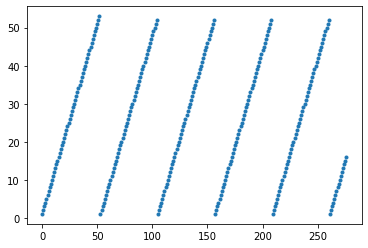

In [194]:
pd.Series(ZB_country.index.week).plot(linestyle='', marker='.')

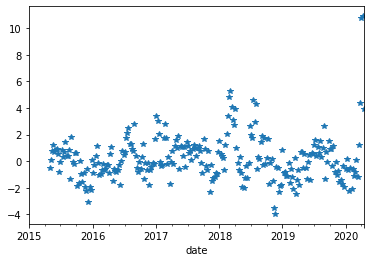

In [195]:
ZB_country.plot()

In [196]:
ZB_country.loc['2016/01/01' : '2019/12/31'].index.week

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            43, 44, 45, 46, 47, 48, 49, 50, 51, 52],
           dtype='int64', name='date', length=208)

In [197]:
import matplotlib
matplotlib.rcParams['lines.linestyle'] = ''
matplotlib.rcParams['lines.marker'] = '*'

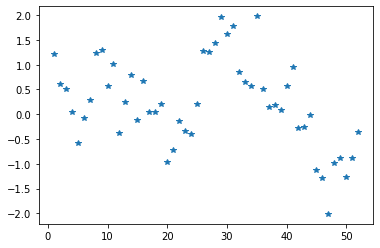

In [198]:
each_week_mean = ZB_country.loc['2016/01/01' : '2019/12/31'].groupby(by=lambda date : date.week).mean()
each_week_mean.plot()

In [199]:
# be very aware of this! if you take rolling average on the multi year weekly mean but not on the zscore itself, you don't filter the baseline
#each_week_mean = pd.concat([each_week_mean.loc[52:52.5], each_week_mean, each_week_mean.loc[1:1.5]]).rolling(3, center=True).mean().dropna()
#each_week_mean.plot()

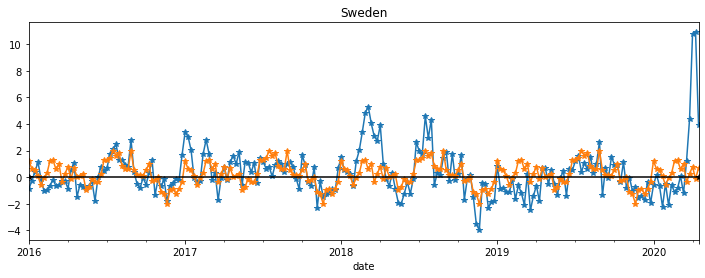

In [200]:
a = pd.concat(5 * [each_week_mean,]).iloc[:len(ZB_country.loc['2016/01/01':])]
a.index = ZB_country.loc['2016/01/01':].index

ax = ZB_country.loc['2016/01/01':].rolling(1, center=True).mean().plot(figsize=(12, 4), linestyle='-', title=country)
a.rolling(1, center=True).mean().plot(linestyle='-')
ax.axhline(y=0, linestyle='-', color='black')

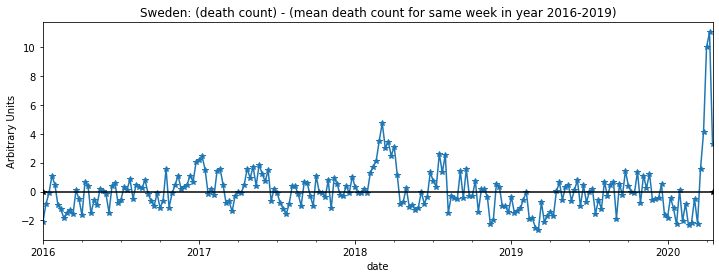

In [201]:
ax = (ZB_country.loc['2016/01/01':] - a).rolling(1, center=True).mean().plot(figsize=(12, 4), linestyle='-', title=f'{country}: (death count) - (mean death count for same week in year 2016-2019)')
ax.set_ylabel('Arbitrary Units')
ax.axhline(y=0, linestyle='-', color='black')

In [150]:
index.week

NameError: name 'index' is not defined

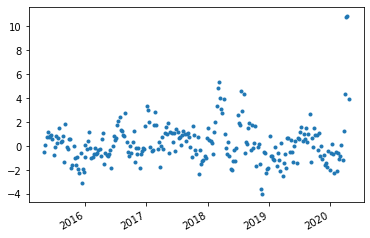

In [21]:
ZB['Total']['Sweden'].plot(linestyle='', marker='.')
#ZB['Total']['Sweden'].groupby(by=lambda t : t.year).mean()

In [322]:
ZB.index[0]

Timestamp('2015-01-04 00:00:00')

In [313]:
recreate_weeks

year  week
0    2015     2
1    2015     3
2    2015     4
3    2015     5
4    2015     6
..    ...   ...
272  2020    13
273  2020    14
274  2020    15
275  2020    16
276  2020    17

[277 rows x 2 columns]

In [314]:
recreate_weeks = pd.DataFrame(data={'year' : ZB.index.year, 'week' : ZB.index.week})
recreate_weeks - pd.Series(zByCountry['weeks']).str.split('-', expand=True).astype(int).rename(columns={0: 'year', 1: 'week'})

year  week
0       0     0
1       0     0
2       0     0
3       0     0
4       0     0
..    ...   ...
272     0     0
273     0     0
274     0     0
275     0     0
276     0     0

[277 rows x 2 columns]

In [ ]:
pd.DataFrame.sort_values()

In [257]:
w = pd.Series(zByCountry['weeks']).str.split('-', expand=True)
w.rename(columns={0:"year", 1:'week'}).sort_values(by=['week', 'year']).iloc[-5:]

year week
104  2016   52
156  2017   52
208  2018   52
260  2019   52
52   2015   53

In [259]:
pd.Series(pooledByAgeGroup['weeks']).str.split('-', expand=True).rename(columns={0:"year", 1:'week'}).sort_values(by=['week', 'year']).iloc[-5:]

year week
206  2019   51
51   2016   52
103  2017   52
155  2018   52
207  2019   52

In [ ]:
pooledByAgeGroup